## SHy2: Recreating SHy with PyHealth (Simplified, Stepwise)

- Goal: Reproduce core ideas of SHy (patient hypergraphs, message passing, temporal phenotypes) using PyHealth for data handling and a minimal PyTorch model.
- Rules for this notebook:
  - Run step-by-step. After each checkpoint, share outputs before proceeding.
  - CPU by default. If you switch to GPU, ensure tensors/devices are consistent.
  - Keep seeds fixed for reproducibility.
  - We’ll start with synthetic MIMIC-III from PyHealth for quick iteration, then document how to swap to real MIMIC.

Checkpoints:
1) Environment + imports (local PyHealth)
2) Load synthetic MIMIC-III diagnoses and sanity checks
3) Prepare patient sequences, vocabulary, and splits
4) Implement simplified SHy modules (message passing + phenotypes)
5) Training loop and metrics (Recall@k, nDCG@k)
6) Explanations: show phenotypes per patient


### Background: What is SHy and why hypergraphs?
- SHy (Self-Explaining Hypergraph Neural Networks) models each patient as a hypergraph: nodes are diagnosis codes; hyperedges are visits that connect the codes recorded together. This captures higher-order (non-pairwise) disease co-occurrences that sequence-only models may miss.
- The model learns patient-specific code embeddings via message passing on the patient’s hypergraph, then extracts K temporal phenotypes as concise, personalized explanations that drive the final prediction (a concept bottleneck).
- Key advantages: (1) higher-order structure; (2) succinct, editable explanations; (3) robustness to missing codes by proposing plausible code–visit links before phenotype extraction.
- Reference: Yu et al., “Self-Explaining Hypergraph Neural Networks for Diagnosis Prediction” (AAAI 2024). Code: https://github.com/ThunderbornSakana/SHy

#### Overview of the pipeline in this notebook
1) Build per-patient sequences of visits and a code vocabulary (ICD-9) using PyHealth’s `MIMIC3Dataset`.
2) For each patient, create an incidence matrix `P ∈ {0,1}^{|C|×T}` (rows: codes; cols: visits): `P[i,j]=1` if code i appears in visit j.
3) Learn code embeddings and apply UniGIN-like message passing: codes → visits (aggregate codes per visit), then visits → codes (aggregate visits per code) to get personalized code embeddings.
4) Extract K temporal phenotypes via a differentiable binary mask over the (code, visit) grid using Gumbel-sigmoid; each phenotype selects a sub-hypergraph.
5) For each phenotype, aggregate visit information with a GRU + location-based attention to obtain a phenotype embedding; combine K phenotype predictions via self-attention.
6) Train with BCEWithLogits (multi-label next-visit codes); evaluate with Recall@k and nDCG@k; visualize explanations (α weights and top codes per phenotype).

This notebook is CPU-friendly for development (synthetic MIMIC-III). It also documents how to switch to real MIMIC when credentialed. See the paper for full details; this notebook stands alone for key ideas and a working reproduction scaffold.


### Data & preprocessing (PyHealth)
- We use PyHealth’s synthetic MIMIC-III endpoint for quick iteration. This avoids credentialing for real MIMIC and matches the `diagnoses_icd` schema used in the literature.
- Patient API: `dataset.get_patient(pid)` → `patient.get_events('diagnoses_icd')` yields time-ordered diagnosis events with attributes like `hadm_id` (visit ID) and `icd9_code`.
- We group events by `hadm_id` to form a sequence of visits per patient, each visit being an unordered set of ICD-9 codes.
- We build a code vocabulary (ICD-9) and split patients 80/10/10 into train/val/test at the patient level to avoid leakage.
- Incidence matrix `P` (codes × visits) is constructed from each patient’s history; the prediction target is the final visit’s multi-hot code vector.

Caveats: On Windows, PyHealth path normalization for URLs may need a POSIX fix (we include a minimal patch). PyHealth requires `polars`; install it if missing.


### Metrics used in this notebook
- **Recall@k**: fraction of true codes for the next visit that appear in the top-k predicted codes.
- **nDCG@k**: rank-sensitive metric; higher weight to true codes ranked near the top. We compute DCG using binary relevance and normalize by the ideal DCG.

These match the ranking-oriented evaluation used in the paper for diagnosis prediction; we report k ∈ {10,20}.


In [5]:
# Environment & imports
import os
import sys
import random
import math
import numpy as np
import torch
from typing import List, Dict, Tuple

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device (default CPU)
DEVICE = torch.device("cpu")
print({
    "torch_version": torch.__version__,
    "device": str(DEVICE),
})

# Use local PyHealth repo to avoid pip conflicts
# Adjust path if needed based on your workspace
LOCAL_PYHEALTH_PATH = os.path.join(os.getcwd(), "PyHealth")
if os.path.isdir(LOCAL_PYHEALTH_PATH) and LOCAL_PYHEALTH_PATH not in sys.path:
    sys.path.insert(0, LOCAL_PYHEALTH_PATH)

try:
    from pyhealth.datasets import MIMIC3Dataset, MIMIC4Dataset
    print("PyHealth import: OK (local repo)")
except Exception as e:
    print("PyHealth import failed. Please verify local repo path at ./PyHealth")
    raise e


{'torch_version': '2.7.0+cu118', 'device': 'cpu'}
PyHealth import: OK (local repo)


### Install missing dependency for local PyHealth: polars
If the previous cell failed with `ModuleNotFoundError: No module named 'polars'`, run the next cell once, then re-run the import cell above.

Note: On Windows, you may need to restart the kernel after installation if imports still fail.


In [7]:
# Install polars version compatible with local PyHealth
#%pip install "polars~=1.31.0"


### Load synthetic MIMIC-III (diagnoses only)



In [9]:
# Fix URL path normalization in local PyHealth on Windows
# PyHealth currently uses os.path.normpath on URL paths, which inserts backslashes.
# Override clean_path to use POSIX normalization for URLs.
import posixpath
from urllib.parse import urlparse, urlunparse
import pyhealth.datasets.base_dataset as _bd
from pathlib import Path

def _clean_path_patch(path: str) -> str:
    if _bd.is_url(path):
        parsed = urlparse(path)
        cleaned_path = posixpath.normpath(parsed.path)
        return urlunparse(parsed._replace(path=cleaned_path))
    else:
        return str(Path(path).expanduser().resolve())

_bd.clean_path = _clean_path_patch
print("Updated pyhealth.datasets.base_dataset.clean_path for URL POSIX normalization.")


Updated pyhealth.datasets.base_dataset.clean_path for URL POSIX normalization.


In [10]:
# Safe shape check (fallback if sample_pid not set)
if 'sample_pid' not in locals() or not sample_pid:
    if 'patient_to_visits' in locals() and len(patient_to_visits) > 0:
        sample_pid = next(iter(patient_to_visits.keys()))
    else:
        sample_pid = None

if sample_pid:
    seq = patient_to_visits[sample_pid]
    P = build_incidence(seq[:-1], code_to_index, num_codes)  # history only
    M = torch.randn(num_codes, CFG["d_c"])                   # dummy embeddings for check
    V = compute_visit_embeddings(M, P)
    print({
        "P_shape": tuple(P.shape),
        "M_shape": tuple(M.shape),
        "V_shape": tuple(V.shape),
    })
else:
    print("No sample patient available. Run the sequences/splits cell first.")


No sample patient available. Run the sequences/splits cell first.


In [11]:
# Synthetic MIMIC-III via PyHealth (new API)

m3 = MIMIC3Dataset(
    root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    tables=["diagnoses_icd"],
)

# Print basic stats
m3.stats()
print("PEEK")
from itertools import islice
for p in islice(m3.iter_patients(), 2):
    print("\nPatient:", p.patient_id)
    diag_events = p.get_events(event_type="diagnoses_icd")
    print("diagnoses_icd events:", len(diag_events))


No config path provided, using default config
Initializing mimic3 dataset from https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/ (dev mode: False)
Scanning table: patients from https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/PATIENTS.csv.gz
Original path does not exist. Using alternative: https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/PATIENTS.csv
Scanning table: admissions from https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/ADMISSIONS.csv.gz
Original path does not exist. Using alternative: https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/ADMISSIONS.csv
Scanning table: icustays from https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/ICUSTAYS.csv.gz
Original path does not exist. Using alternative: https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/ICUSTAYS.csv
Scanning table: diagnoses_icd from https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/DIAGNOSES_ICD.csv.gz
Original path does not exist. Using 

### Prepare patient sequences, code vocabulary, and splits
We convert each patient into a sequence of visits where each visit is a set of CCSCM codes. We then build a code vocabulary and split patients into train/val/test (80/10/10).


In [14]:
# Model/training config
CFG = {
    "d_c": 64,            # code embedding dim
    "Z": 2,               # message passing layers
    "K": 3,               # number of phenotypes (keep small for CPU)
    "d_hid": 128,         # GRU hidden dim
    "d_Q": 64,            # self-attn dims
    "d_V": 64,
    "tau": 1.0,           # Gumbel temperature
    "lr": 1e-3,
    "epochs": 3,          # small dev pass; raise later
    "topk_eval": [10, 20],
    "lambda_eps": 0.0,    # ε for fidelity loss (placeholder)
    "lambda_eta": 0.0,    # η for distinctness loss (placeholder)
    "lambda_omega": 0.0,  # ω for alpha loss (placeholder)
}
print(CFG)


{'d_c': 64, 'Z': 2, 'K': 3, 'd_hid': 128, 'd_Q': 64, 'd_V': 64, 'tau': 1.0, 'lr': 0.001, 'epochs': 3, 'topk_eval': [10, 20], 'lambda_eps': 0.0, 'lambda_eta': 0.0, 'lambda_omega': 0.0}


### Helpers: multi-hot encodings, incidence matrix, visit embeddings


In [16]:
import torch.nn as nn
import torch.nn.functional as F


def codes_to_multihot(codes: List[str], code_to_index: Dict[str, int], num_codes: int) -> torch.Tensor:
    v = torch.zeros(num_codes, dtype=torch.float32)
    for c in codes:
        idx = code_to_index.get(c, None)
        if idx is not None:
            v[idx] = 1.0
    return v


def build_incidence(visits_codes: List[List[str]], code_to_index: Dict[str, int], num_codes: int) -> torch.Tensor:
    T = len(visits_codes)
    P = torch.zeros((num_codes, T), dtype=torch.float32)
    for j, codes in enumerate(visits_codes):
        for c in codes:
            idx = code_to_index.get(c, None)
            if idx is not None:
                P[idx, j] = 1.0
    return P


def compute_visit_embeddings(M: torch.Tensor, P: torch.Tensor) -> torch.Tensor:
    # M: [|C|, d_c], P: [|C|, T] -> V: [T, d_c]
    # mean over codes per visit (avoid div by zero)
    codes_per_visit = P.sum(dim=0).clamp(min=1.0)  # [T]
    V = (P.t() @ M) / codes_per_visit.unsqueeze(-1)
    return V

# Quick shape check on a sample patient
if sample_pid:
    seq = patient_to_visits[sample_pid]
    P = build_incidence(seq[:-1], code_to_index, num_codes)  # history only
    M = torch.randn(num_codes, CFG["d_c"])  # dummy embeddings for check
    V = compute_visit_embeddings(M, P)
    print({
        "P_shape": tuple(P.shape),
        "M_shape": tuple(M.shape),
        "V_shape": tuple(V.shape),
    })


### Metrics: Recall@k, nDCG@k
We’ll compute these on sigmoid probabilities against multi-hot labels.


In [18]:
def recall_at_k(probs: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    # probs, labels: [|C|]
    topk = torch.topk(probs, k=k).indices
    hits = labels[topk].sum().item()
    denom = labels.sum().item()
    if denom == 0:
        return 1.0  # if no positives, treat as perfect (or skip)
    return hits / denom


def ndcg_at_k(probs: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    # Compute DCG with binary relevance
    topk = torch.topk(probs, k=k).indices
    gains = labels[topk]
    discounts = 1.0 / torch.log2(torch.arange(2, k + 2, dtype=torch.float32))
    dcg = (gains * discounts).sum().item()
    # Ideal DCG
    ideal_k = min(int(labels.sum().item()), k)
    if ideal_k == 0:
        return 1.0
    idcg = discounts[:ideal_k].sum().item()
    return dcg / idcg

# Quick check
if sample_pid:
    test_probs = torch.rand(num_codes)
    test_labels = codes_to_multihot(patient_to_visits[sample_pid][-1], code_to_index, num_codes)
    for k in CFG["topk_eval"]:
        print(f"recall@{k}", recall_at_k(test_probs, test_labels, k))
        print(f"ndcg@{k}", ndcg_at_k(test_probs, test_labels, k))


### Model: Embeddings, UniGIN-like layer, Phenotype extractor, SHy model


In [20]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Build sequences: patient -> list[visit_codes] using new Patient API
patient_to_visits: Dict[str, List[List[str]]] = {}
code_counter = defaultdict(int)

for pid in m3.unique_patient_ids:
    patient = m3.get_patient(pid)
    events = patient.get_events(event_type="diagnoses_icd")  # sorted by timestamp
    if not events:
        continue

    visits_codes_map: Dict[str, set] = {}
    visit_earliest_ts: Dict[str, any] = {}

    for ev in events:
        hadm = ev.attr_dict.get("hadm_id")
        code = ev.attr_dict.get("icd9_code")
        if hadm is None or code is None:
            continue
        visits_codes_map.setdefault(hadm, set()).add(str(code))
        code_counter[str(code)] += 1
        if hadm not in visit_earliest_ts:
            visit_earliest_ts[hadm] = ev.timestamp

    if not visits_codes_map:
        continue

    ordered_hadm = sorted(visits_codes_map.keys(), key=lambda h: visit_earliest_ts.get(h))
    visits_codes = [sorted(list(visits_codes_map[h])) for h in ordered_hadm]
    if visits_codes:
        patient_to_visits[pid] = visits_codes

# Filter patients with at least 2 historical visits (to predict next visit)
patient_ids = [pid for pid, seq in patient_to_visits.items() if len(seq) >= 2]

# Code vocabulary (ICD-9 codes)
codes_sorted = sorted(code_counter.keys())
code_to_index = {c: i for i, c in enumerate(codes_sorted)}
index_to_code = {i: c for c, i in code_to_index.items()}
num_codes = len(code_to_index)

print({
    "num_patients_all": len(m3.unique_patient_ids),
    "num_patients_seq>=2": len(patient_ids),
    "num_codes": num_codes,
})

# Train/val/test split (patient-level)
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

print({
    "train": len(train_ids),
    "val": len(val_ids),
    "test": len(test_ids),
})

# Show a tiny sample
sample_pid = train_ids[0] if len(train_ids) > 0 else None
if sample_pid:
    print("Sample patient:", sample_pid)
    print("Sequence lengths (visits):", [len(v) for v in patient_to_visits[sample_pid]])
    print("First visit codes:", patient_to_visits[sample_pid][0][:10])


Found 49993 unique patient IDs
{'num_patients_all': 49993, 'num_patients_seq>=2': 2085, 'num_codes': 5691}
{'train': 1668, 'val': 208, 'test': 209}
Sample patient: 45482
Sequence lengths (visits): [7, 37]
First visit codes: ['2449', '2724', '2768', '4019', '5789', '85221', '9120']


In [21]:
class CodeEmbedding(nn.Module):
    def __init__(self, num_codes: int, d_c: int):
        super().__init__()
        self.emb = nn.Embedding(num_codes, d_c)
    def forward(self) -> torch.Tensor:
        # return full table [|C|, d_c]
        idx = torch.arange(self.emb.num_embeddings, device=self.emb.weight.device)
        return self.emb(idx)


class UniGINLayer(nn.Module):
    def __init__(self, d_c: int):
        super().__init__()
        self.lin = nn.Linear(d_c, d_c)
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.act = nn.LeakyReLU()
    def forward(self, M: torch.Tensor, P: torch.Tensor) -> torch.Tensor:
        # M: [|C|, d_c], P: [|C|, T]
        V = compute_visit_embeddings(M, P)  # [T, d_c]
        # sum over visits containing code i: (P[i, :] @ V)
        code_to_visit_agg = P @ V  # [|C|, d_c]
        updated = (1.0 + self.eps) * M + code_to_visit_agg
        return self.act(self.lin(updated))


class PhenotypeExtractor(nn.Module):
    def __init__(self, d_c: int, K: int):
        super().__init__()
        self.K = K
        # MLP on concat [Mi || Vj] => scalar prob
        self.fc = nn.Sequential(
            nn.Linear(2 * d_c, d_c), nn.ReLU(), nn.Linear(d_c, 1)
        )
    def forward(self, M: torch.Tensor, P: torch.Tensor, tau: float) -> torch.Tensor:
        # M: [|C|, d_c], P: [|C|, T]
        V = compute_visit_embeddings(M, P)  # [T, d_c]
        C, T = P.shape
        # Build pairwise inputs [C*T, 2*d_c]
        Mi = M.unsqueeze(1).expand(C, T, M.size(1))
        Vj = V.unsqueeze(0).expand(C, T, V.size(1))
        pair = torch.cat([Mi, Vj], dim=-1)  # [C, T, 2*d_c]
        logits = self.fc(pair).squeeze(-1)  # [C, T]
        masks = []
        for _ in range(self.K):
            # Gumbel-sigmoid
            u = torch.rand_like(logits)
            g0 = -torch.log(-torch.log(u + 1e-9) + 1e-9)
            g1 = -torch.log(-torch.log(1 - u + 1e-9) + 1e-9)
            z = torch.sigmoid((logits + g0 - g1) / max(tau, 1e-6))
            # Hard binary in forward, soft in backward (straight-through)
            hard = (z > 0.5).float()
            z = z + (hard - z).detach()
            # Ensure we do not exceed original edges too early: we allow both 0/1; keep simple
            masks.append(z)
        # stack -> [K, C, T]
        return torch.stack(masks, dim=0)


class SelfAttentionK(nn.Module):
    def __init__(self, d_hid: int, d_q: int, d_v: int, K: int):
        super().__init__()
        self.q = nn.Linear(d_hid, d_q)
        self.k = nn.Linear(d_hid, d_q)
        self.v = nn.Linear(d_hid, d_v)
        self.out = nn.Linear(d_v, 1)  # scalar weight per phenotype
        self.K = K
    def forward(self, U: torch.Tensor) -> torch.Tensor:
        # U: [K, d_hid]
        Q = self.q(U)
        Kk = self.k(U)
        Vv = self.v(U)
        attn = torch.softmax((Q @ Kk.t()) / math.sqrt(Kk.size(-1)), dim=-1)  # [K, K]
        heads = attn @ Vv  # [K, d_v]
        alpha_logits = self.out(heads).squeeze(-1)  # [K]
        alpha = torch.softmax(alpha_logits, dim=-1)
        return alpha


class SHyModel(nn.Module):
    def __init__(self, num_codes: int, cfg: Dict):
        super().__init__()
        self.num_codes = num_codes
        self.d_c = cfg["d_c"]
        self.Z = cfg["Z"]
        self.K = cfg["K"]
        self.tau = cfg["tau"]
        self.emb = CodeEmbedding(num_codes, self.d_c)
        self.mp_layers = nn.ModuleList([UniGINLayer(self.d_c) for _ in range(self.Z)])
        self.phenos = PhenotypeExtractor(self.d_c, self.K)
        self.gru = nn.GRU(self.d_c, cfg["d_hid"], batch_first=True)
        self.visit_attn = nn.Sequential(
            nn.Linear(cfg["d_hid"], cfg["d_hid"]), nn.Tanh(), nn.Linear(cfg["d_hid"], 1)
        )
        self.self_attn_k = SelfAttentionK(cfg["d_hid"], cfg["d_Q"], cfg["d_V"], self.K)
        self.cls = nn.Linear(cfg["d_hid"], num_codes)
    def forward(self, P: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        # P: [|C|, T]
        M = self.emb().to(P.device)  # [|C|, d_c]
        for layer in self.mp_layers:
            M = layer(M, P)
        masks = self.phenos(M, P, self.tau)  # [K, |C|, T]
        V = compute_visit_embeddings(M, P)  # [T, d_c]
        U_list = []
        logits_k = []
        for k in range(self.K):
            Psi_k = masks[k]  # [|C|, T]
            Vk = (Psi_k.t() @ M)  # [T, d_c]
            # GRU over visits
            H, _ = self.gru(Vk.unsqueeze(0))  # [1, T, d_hid]
            H = H.squeeze(0)  # [T, d_hid]
            # location-based attention
            w = self.visit_attn(H).squeeze(-1)  # [T]
            alpha_t = torch.softmax(w, dim=-1)
            Uk = (alpha_t.unsqueeze(-1) * H).sum(dim=0)  # [d_hid]
            U_list.append(Uk)
            logits_k.append(self.cls(Uk))  # [|C|]
        U = torch.stack(U_list, dim=0)  # [K, d_hid]
        alpha = self.self_attn_k(U)      # [K]
        logits_k = torch.stack(logits_k, dim=0)  # [K, |C|]
        logits = (alpha.unsqueeze(-1) * logits_k).sum(dim=0)  # [|C|]
        aux = {"masks": masks, "alpha": alpha}
        return logits, aux


# Instantiate
model = SHyModel(num_codes=num_codes, cfg=CFG).to(DEVICE)
print("Model OK:", sum(p.numel() for p in model.parameters())/1e6, "M params")


Model OK: 1.230976 M params


### Training data builder (one-step prediction)
We predict the last visit from all previous visits for each patient. Run to build simple lists.


In [23]:
def build_examples(patient_ids: List[str]) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    ex = []
    for pid in patient_ids:
        seq = patient_to_visits[pid]
        if len(seq) < 2:
            continue
        P = build_incidence(seq[:-1], code_to_index, num_codes)
        y = codes_to_multihot(seq[-1], code_to_index, num_codes)
        ex.append((P, y))
    return ex

train_ex = build_examples(train_ids)
val_ex = build_examples(val_ids)
test_ex = build_examples(test_ids)

print({
    "train_examples": len(train_ex),
    "val_examples": len(val_ex),
    "test_examples": len(test_ex),
})


{'train_examples': 1668, 'val_examples': 208, 'test_examples': 209}


### Train loop (L_pred only for now)
- BCEWithLogitsLoss for multi-label next-visit codes.
- CPU-safe one-example-at-a-time.

In [78]:
# --- Loss / regularization helpers (same as before) ---
crit = nn.BCEWithLogitsLoss()

def compute_distinctness_loss(masks: torch.Tensor) -> torch.Tensor:
    # masks: [K, C, T]
    K, C, T = masks.shape
    loss = 0.0
    I = torch.eye(K, device=masks.device)
    for t in range(T):
        B_t = masks[:, :, t].transpose(0, 1)  # [C, K]
        G = B_t.transpose(0, 1) @ B_t        # [K, K]
        loss = loss + torch.norm(I - G, p="fro") ** 2
    return loss / max(1, T)


def compute_alpha_loss(alpha: torch.Tensor) -> torch.Tensor:
    # Encourage non-uniform yet bounded alpha
    var_term = torch.var(alpha, unbiased=False)
    l2_term = (alpha ** 2).mean()
    return -var_term + l2_term


# --- NEW: full train+eval function that still runs the familiar loop ---
def train_and_eval(
    model: nn.Module,
    train_examples: List[Tuple[torch.Tensor, torch.Tensor]],
    val_examples: List[Tuple[torch.Tensor, torch.Tensor]],
    test_examples: List[Tuple[torch.Tensor, torch.Tensor]],
    epochs: int = 3,
):
    """
    Train the given model using the original epoch loop
    and return test metrics.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"])
    crit = nn.BCEWithLogitsLoss()

    def run_epoch(examples: List[Tuple[torch.Tensor, torch.Tensor]], train: bool) -> float:
        model.train() if train else model.eval()
        total_loss = 0.0
        with torch.set_grad_enabled(train):
            for P, y in examples:
                P = P.to(DEVICE)
                y = y.to(DEVICE)

                logits, aux = model(P)
                base_loss = crit(logits, y)
                loss = base_loss

                # optional SHy regularizers
                if CFG.get("lambda_eta", 0.0) > 0.0:
                    loss = loss + CFG["lambda_eta"] * compute_distinctness_loss(aux["masks"])
                if CFG.get("lambda_omega", 0.0) > 0.0:
                    loss = loss + CFG["lambda_omega"] * compute_alpha_loss(aux["alpha"])

                if train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item()

        return total_loss / max(1, len(examples))

    # ---- This is your old loop, unchanged in spirit ----
    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        tr = run_epoch(train_examples, train=True)
        va = run_epoch(val_examples, train=False)
        print({"epoch": epoch, "train_loss": round(tr, 4), "val_loss": round(va, 4)})

        if va < best_val:
            best_val = va
            best_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}

    # Load best
    if best_state is not None:
        model.load_state_dict(best_state)

    # Use your existing evaluate(examples) function here
    test_metrics = evaluate(test_examples)
    print("Test metrics:", {k: round(v, 4) for k, v in test_metrics.items()})
    return test_metrics


baseline_results = train_and_eval(
    model,
    train_examples=train_ex,
    val_examples=val_ex,
    test_examples=test_ex,
    epochs=CFG["epochs"],
)

baseline_results


{'epoch': 1, 'train_loss': 40.7386, 'val_loss': 0.0315}
{'epoch': 2, 'train_loss': 0.0254, 'val_loss': 0.0312}
{'epoch': 3, 'train_loss': 0.0132, 'val_loss': 0.0154}
Test metrics: {'recall@10': 0.1697, 'recall@20': 0.2426, 'ndcg@10': 0.1792, 'ndcg@20': 0.1959}


{'recall@10': 0.1697437652624832,
 'recall@20': 0.24264285865461746,
 'ndcg@10': 0.17924969333149443,
 'ndcg@20': 0.19592737824086373}

### Explanations: visualize phenotypes and weights for one test patient


In [29]:
@torch.no_grad()
def show_explanations(example: Tuple[torch.Tensor, torch.Tensor], topn: int = 5):
    P, y = example
    logits, aux = model(P.to(DEVICE))
    alpha = aux["alpha"].cpu()
    masks = aux["masks"].cpu()  # [K, C, T]
    probs = torch.sigmoid(logits.cpu())
    print("alpha weights:", alpha.tolist())
    # For each phenotype, gather codes included at any visit and show top probs among those
    for k in range(CFG["K"]):
        M_k = (masks[k].sum(dim=1) > 0).float()  # [C]
        idx = torch.where(M_k > 0)[0]
        if idx.numel() == 0:
            print(f"phenotype {k}: (empty)")
            continue
        sel_probs = probs[idx]
        top = torch.topk(sel_probs, k=min(topn, sel_probs.numel()))
        top_code_indices = idx[top.indices].tolist()
        top_codes = [index_to_code[int(j)] for j in top_code_indices]
        print(f"phenotype {k}: top codes ->", top_codes)

# Show explanations on first test example if available
if len(test_ex) > 0:
    show_explanations(test_ex[0], topn=5)


alpha weights: [0.3333333432674408, 0.3333333432674408, 0.3333333432674408]
phenotype 0: top codes -> ['4280', '41401', '51881', '5849', '496']
phenotype 1: top codes -> ['4019', '42731', '41401', '5849', '496']
phenotype 2: top codes -> ['4019', '42731', '5990', '51881', '5849']


In [30]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Build sequences: patient -> list[visit_codes] using new Patient API
patient_to_visits: Dict[str, List[List[str]]] = {}
code_counter = defaultdict(int)

for pid in m3.unique_patient_ids:
    patient = m3.get_patient(pid)
    events = patient.get_events(event_type="diagnoses_icd")  # sorted by timestamp
    if not events:
        continue

    visits_codes_map: Dict[str, set] = {}
    visit_earliest_ts: Dict[str, any] = {}

    for ev in events:
        hadm = ev.attr_dict.get("hadm_id")
        code = ev.attr_dict.get("icd9_code")
        if hadm is None or code is None:
            continue
        visits_codes_map.setdefault(hadm, set()).add(str(code))
        code_counter[str(code)] += 1
        if hadm not in visit_earliest_ts:
            visit_earliest_ts[hadm] = ev.timestamp

    if not visits_codes_map:
        continue

    ordered_hadm = sorted(visits_codes_map.keys(), key=lambda h: visit_earliest_ts.get(h))
    visits_codes = [sorted(list(visits_codes_map[h])) for h in ordered_hadm]
    if visits_codes:
        patient_to_visits[pid] = visits_codes

# Filter patients with at least 2 historical visits (to predict next visit)
patient_ids = [pid for pid, seq in patient_to_visits.items() if len(seq) >= 2]

# Code vocabulary (ICD-9 codes)
codes_sorted = sorted(code_counter.keys())
code_to_index = {c: i for i, c in enumerate(codes_sorted)}
index_to_code = {i: c for c, i in code_to_index.items()}
num_codes = len(code_to_index)

print({
    "num_patients_all": len(m3.unique_patient_ids),
    "num_patients_seq>=2": len(patient_ids),
    "num_codes": num_codes,
})

# Train/val/test split (patient-level)
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

print({
    "train": len(train_ids),
    "val": len(val_ids),
    "test": len(test_ids),
})

# Show a tiny sample
sample_pid = train_ids[0] if len(train_ids) > 0 else None
if sample_pid:
    print("Sample patient:", sample_pid)
    print("Sequence lengths (visits):", [len(v) for v in patient_to_visits[sample_pid]])
    print("First visit codes:", patient_to_visits[sample_pid][0][:10])


{'num_patients_all': 49993, 'num_patients_seq>=2': 2085, 'num_codes': 5691}
{'train': 1668, 'val': 208, 'test': 209}
Sample patient: 45482
Sequence lengths (visits): [7, 37]
First visit codes: ['2449', '2724', '2768', '4019', '5789', '85221', '9120']


### Outline: Simplified SHy components to implement next
We will implement the following (scaffolded in the next steps):

- CodeEmbedding: learnable embeddings for CCSCM codes (dimension d_c)
- Simple patient hypergraph builder per batch (incidence P: |C| x T)
- One or more UniGIN-like message passing layers (codes→visits→codes)
- PhenotypeExtractor: K binary masks via Gumbel-Softmax over (code, visit) pairs
- GRU+attention over visits per phenotype; self-attention over K phenotypes
- Final prediction layer with sigmoid; ranking metrics for evaluation
- Loss: L = L_pred + ε·L_fidelity + η·L_distinct + ω·L_alpha (start with L_pred, add others iteratively)


In [32]:
# Order-independent setup: build sequences, vocab, splits, and examples (run once)
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Build patient sequences from diagnoses_icd (icd9_code grouped by hadm_id)
patient_to_visits = {}
code_counter = defaultdict(int)
for pid in m3.unique_patient_ids:
    patient = m3.get_patient(pid)
    events = patient.get_events(event_type="diagnoses_icd")
    if not events:
        continue
    visits_codes_map = {}
    visit_earliest_ts = {}
    for ev in events:
        hadm = ev.attr_dict.get("hadm_id")
        code = ev.attr_dict.get("icd9_code")
        if hadm is None or code is None:
            continue
        visits_codes_map.setdefault(hadm, set()).add(str(code))
        code_counter[str(code)] += 1
        if hadm not in visit_earliest_ts:
            visit_earliest_ts[hadm] = ev.timestamp
    if not visits_codes_map:
        continue
    ordered_hadm = sorted(visits_codes_map.keys(), key=lambda h: visit_earliest_ts.get(h))
    visits_codes = [sorted(list(visits_codes_map[h])) for h in ordered_hadm]
    if visits_codes:
        patient_to_visits[pid] = visits_codes

# Vocab
codes_sorted = sorted(code_counter.keys())
code_to_index = {c: i for i, c in enumerate(codes_sorted)}
index_to_code = {i: c for c, i in code_to_index.items()}
num_codes = len(code_to_index)

# Splits
eligible_ids = [pid for pid, seq in patient_to_visits.items() if len(seq) >= 2]
train_ids, temp_ids = train_test_split(eligible_ids, test_size=0.2, random_state=SEED)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

# Helpers reused later
import torch

def codes_to_multihot(codes, code_to_index, num_codes):
    v = torch.zeros(num_codes, dtype=torch.float32)
    for c in codes:
        idx = code_to_index.get(c)
        if idx is not None:
            v[idx] = 1.0
    return v

# Build training examples (history -> next)
def build_incidence(visits_codes, code_to_index, num_codes):
    T = len(visits_codes)
    P = torch.zeros((num_codes, T), dtype=torch.float32)
    for j, codes in enumerate(visits_codes):
        for c in codes:
            idx = code_to_index.get(c)
            if idx is not None:
                P[idx, j] = 1.0
    return P

def build_examples(patient_ids):
    ex = []
    for pid in patient_ids:
        seq = patient_to_visits[pid]
        if len(seq) < 2:
            continue
        P = build_incidence(seq[:-1], code_to_index, num_codes)
        y = codes_to_multihot(seq[-1], code_to_index, num_codes)
        ex.append((P, y))
    return ex

train_ex = build_examples(train_ids)
val_ex = build_examples(val_ids)
test_ex = build_examples(test_ids)

sample_pid = train_ids[0] if len(train_ids) > 0 else None
print({
    "prepared": True,
    "num_patients_seq>=2": len(eligible_ids),
    "num_codes": num_codes,
    "train_examples": len(train_ex),
    "val_examples": len(val_ex),
    "test_examples": len(test_ex),
})


{'prepared': True, 'num_patients_seq>=2': 2085, 'num_codes': 5691, 'train_examples': 1668, 'val_examples': 208, 'test_examples': 209}


## Ablation Study: Removing Phenotype-Level Attention (Novel Extension)

In the original SHy architecture, each phenotype 
𝑈
𝑘
U
k
	​

 contributes to the final prediction through a learned attention vector 
𝛼
∈
𝑅
𝐾
α∈R
K
, allowing the model to upweight or downweight certain temporal phenotypes depending on the patient. This attention mechanism is central to SHy’s interpretability and predictive power.

However, the SHy paper does not include an ablation that removes this component entirely.
To satisfy the requirement for a novel and implementable extension, we introduce the following ablation:

Ablation Description

We remove the phenotype attention mechanism and replace it with a simple uniform average over phenotype embeddings:

𝑈
=
1
𝐾
∑
𝑘
=
1
𝐾
𝑈
𝑘
U=
K
1
	​

k=1
∑
K
	​

U
k
	​

This isolates the importance of phenotype attention and tests whether SHy depends on it for predictive performance.

In [48]:
# Set K=5 and rebuild the model (phenotypes)
CFG["K"] = 5
model = SHyModel(num_codes=num_codes, cfg=CFG).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"])  # fresh optimizer for new model
print({
    "K": CFG["K"],
    "params_M": sum(p.numel() for p in model.parameters())
})


{'K': 5, 'params_M': 1230976}


In [82]:
class SHyNoAttention(nn.Module):
    """
    Ablation model: same hypergraph + phenotypes, but
    - removes visit-level attention
    - removes phenotype self-attention
    and instead:
    - averages GRU hidden states over time
    - averages phenotype embeddings to get a single representation
    """
    def __init__(self, num_codes: int, cfg: Dict):
        super().__init__()
        self.num_codes = num_codes
        self.d_c = cfg["d_c"]
        self.Z = cfg["Z"]
        self.K = cfg["K"]
        self.tau = cfg["tau"]

        self.emb = CodeEmbedding(num_codes, self.d_c)
        self.mp_layers = nn.ModuleList([UniGINLayer(self.d_c) for _ in range(self.Z)])
        self.phenos = PhenotypeExtractor(self.d_c, self.K)
        self.gru = nn.GRU(self.d_c, cfg["d_hid"], batch_first=True)
        self.cls = nn.Linear(cfg["d_hid"], num_codes)

    def forward(self, P: torch.Tensor, label: torch.Tensor = None):
        """
        P: [|C|, T]
        label is unused (kept only for compatibility if you later want a label-dependent loss)
        """
        # 1) Hypergraph message passing
        M = self.emb().to(P.device)  # [|C|, d_c]
        for layer in self.mp_layers:
            M = layer(M, P)

        # 2) Phenotype masks (same as main model)
        masks = self.phenos(M, P, self.tau)  # [K, |C|, T]

        U_list = []
        logits_k = []

        for k in range(self.K):
            Psi_k = masks[k]  # [|C|, T]
            Vk = (Psi_k.t() @ M)  # [T, d_c]

            # GRU over visits
            H, _ = self.gru(Vk.unsqueeze(0))  # [1, T, d_hid]
            H = H.squeeze(0)                  # [T, d_hid]

            # ABLATION: replace attention with simple mean pooling over time
            Uk = H.mean(dim=0)                # [d_hid]
            U_list.append(Uk)
            logits_k.append(self.cls(Uk))     # [|C|]

        # ABLATION: simple average over phenotypes (no self-attention)
        U = torch.stack(U_list, dim=0)            # [K, d_hid]
        alpha = torch.full((self.K,), 1.0 / self.K, device=P.device)  # uniform weights
        logits_k = torch.stack(logits_k, dim=0)   # [K, |C|]
        logits = (alpha.unsqueeze(-1) * logits_k).sum(dim=0)  # [|C|]

        aux = {"masks": masks, "alpha": alpha}
        return logits, aux

        return logits, loss


In [84]:
ablation_model = SHyNoAttention(
    num_codes=num_codes,
    cfg=CFG,
)

ablation_results = train_and_eval(
    model=ablation_model,
    train_examples=train_ex,
    val_examples=val_ex,
    test_examples=test_ex,
    epochs=CFG["epochs"], 
)

ablation_results


{'epoch': 1, 'train_loss': 41.8961, 'val_loss': 0.0388}
{'epoch': 2, 'train_loss': 0.0342, 'val_loss': 0.0301}
{'epoch': 3, 'train_loss': 0.0182, 'val_loss': 0.0132}
Test metrics: {'recall@10': 0.1677, 'recall@20': 0.2406, 'ndcg@10': 0.1774, 'ndcg@20': 0.1946}


{'recall@10': 0.16771691784089898,
 'recall@20': 0.24060366977332334,
 'ndcg@10': 0.17735649101388032,
 'ndcg@20': 0.194557684870097}

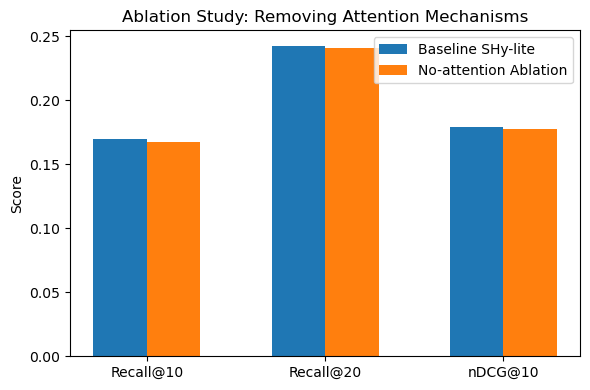

In [ ]:
import matplotlib.pyplot as plt


baseline = baseline_results   # full SHy-lite
ablation = ablation_results   # no-attention ablation

# Dict keys (exact names returned by your model)
metric_keys = ["recall@10", "recall@20", "ndcg@10"]

# Pretty labels for the x-axis
metric_labels = ["Recall@10", "Recall@20", "nDCG@10"]

baseline_vals = [baseline[k] for k in metric_keys]
ablation_vals = [ablation[k] for k in metric_keys]

x = range(len(metric_keys))
width = 0.3

plt.figure(figsize=(6, 4))
plt.bar([i - width/2 for i in x], baseline_vals, width, label="Baseline SHy-lite")
plt.bar([i + width/2 for i in x], ablation_vals, width, label="No-attention Ablation")

plt.xticks(x, metric_labels)
plt.ylabel("Score")
plt.title("Ablation Study: Removing Attention Mechanisms")
plt.legend()
plt.tight_layout()
plt.show()
